In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary
from comet_ml import Experiment

# Local imports
sys.path.append("/Users/leo/Desktop/Thesis/utils/")
sys.path.append("/Users/leo/Desktop/Thesis/models/")

from helper_functions import (delete_ds_store,plot_metrics,test,train,set_device,mean_std_finder,load_model)
from EPSA import SPC
from MBNV3 import MBNV3Creator
from config import comet_token, project_name, workspace
from torchvision.models import (mobilenet_v3_small, MobileNet_V3_Small_Weights as weights_small)

# Setting the seed for reproducibility
torch.manual_seed(42)

In [2]:
prms = {
    "backbone": mobilenet_v3_small,
    "weights": None,
    "module": SPC,
    "module_alias": "SPC",
    "data_path": "/Users/leo/Desktop/Thesis/data/vgg_50/",
    "batch_size": 32,
    "img_size": 224,
    "num_classes": 50,
    "epochs": 50,
    "learning_rate": 0.0001,
    "device": set_device(),
    "model": None,
    "experiment": Experiment(api_key=comet_token, project_name=project_name, workspace=workspace, log_code=True),
    "load_model": False,
}
prms["model_save_path"] = f"./output/{prms['module_alias']}_{prms['data_path'].split('/')[-2]}.pth"

model = prms["model"] = MBNV3Creator(prms["backbone"], prms["num_classes"], prms["weights"], prms["device"], prms["module"])
delete_ds_store(prms["data_path"])

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/leothesouthafrican/test/ecf0d992a07445a29f4a0215833cb68c



In [3]:
#mean, std = mean_std_finder(prms["data_path"])
mean, std = torch.tensor([0.5235, 0.4358, 0.3905]), torch.tensor([0.2993, 0.2770, 0.2729])

train_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
#Accessing the data
train_data = torchvision.datasets.ImageFolder(prms["data_path"] + "train/", transform=train_transform)
val_data = torchvision.datasets.ImageFolder(prms["data_path"] + "val/", transform=test_transform)
test_data = torchvision.datasets.ImageFolder(prms["data_path"] + "test/", transform=test_transform)

#Creating the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=prms["batch_size"], shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


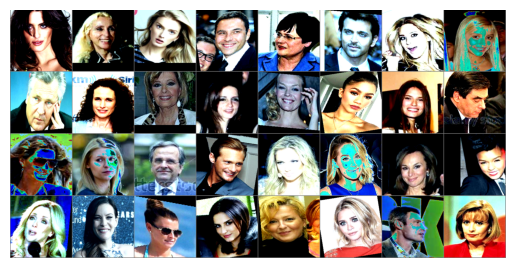

In [5]:
#display random images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
#build the model
model = load_model(model.build(), prms["model_save_path"]) if prms["load_model"] else model.build(set_all_trainable=True)

# Loss and optimizer
criterion = nn.CrossEntropyLoss().to(prms["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=prms["learning_rate"])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

prms["experiment"].log_parameters({"loss": criterion, "optimizer": optimizer}) if prms["experiment"] else None

SE layers: [1, 4, 5, 6, 7, 8, 9, 10, 11]
prev_out_channels: 96
prev_out_channels: 240
prev_out_channels: 240
prev_out_channels: 120
prev_out_channels: 144
prev_out_channels: 288
prev_out_channels: 576
prev_out_channels: 576
<class 'CBAM._CBAM'> inserted in the following layers: [1, 4, 5, 6, 7, 8, 9, 10, 11]
Weights initialized for <class 'CBAM._CBAM'> inserted in the following layers: [1, 4, 5, 6, 7, 8, 9, 10, 11] as well as the last layer.
Grads set to True for [1, 4, 5, 6, 7, 8, 9, 10, 11] and the last layer. (False for the rest)


In [7]:
model_summary = summary(model, input_size=(1, 3, prms["img_size"], prms["img_size"]),
        col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds", "trainable"],
        col_width = 20,
        row_settings = ["var_names"],
        depth=10)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
prms["experiment"].log_metric("total_params", total_params) if prms["experiment"] else None

model_summary

/Users/leo/Desktop/Thesis/thesis_env/lib/python3.11/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds            Trainable
MobileNetV3 (MobileNetV3)                                    [1, 3, 224, 224]     [1, 200]             --                   --                   --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 576, 7, 7]       --                   --                   --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 16, 112, 112]    --                   --                   --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 16, 112, 112]    432                  [3, 3]               5,419,008            True
│    │    └─BatchNorm2d (1)                                  [1, 16, 112, 112]    [1, 16, 112, 112]    32                   --              

In [8]:
#train the model
train_losses, train_acc, val_losses, val_acc = train(model, train_loader, val_loader, criterion, optimizer, scheduler, hyper_params = prms, verbose = 2, test_transform = train_transform, experiment=prms["experiment"])

#plot the training and validation metrics
plot_metrics(train_losses, train_acc, val_losses, val_acc)

  1%|          | 27/2709 [00:08<10:06,  4.42it/s] 

In [ ]:
#test the model
test(model, test_loader, criterion, hyper_params = prms, experiment = prms["experiment"])

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/leothesouthafrican/mbnv3-vgg-200/26f5f5c44927452da581243bd2586faf
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     inference_time  : 0.002954615010441019
COMET INFO:     test_accuracy   : 0.864669919013977
COMET INFO:     test_loss       : 0.6263485046291761
COMET INFO:     total_params    : 1375266
COMET INFO:     train_acc [50]  : (0.04175560548901558, 0.9657555818557739)
COMET INFO:     train_loss [50] : (0.11935453454573017, 4.636355410489149)
COMET INFO:     val_acc [50]    : (0.08871851116418839, 0.8675611615180969)
COMET INFO:     val_loss [50]   : (0.5934110092614274, 4.060624836917862)
COMET INFO:   Parameters:

Test loss: 0.626.. 
Test accuracy: 0.865
Test Time: 0.0m 32s 355ms


COMET INFO: Please wait for metadata to finish uploading (timeout is 3600 seconds)


(0.6263485046291761, tensor(0.8647, device='mps:0'))